# Chlorophyll A Data Vis Workbook
### Amy Phung, March 2020

In [195]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)

pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Imports

In [2]:
%matplotlib inline
import scipy
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import netCDF4
import itertools

### Globals
Defined here to make code a bit more readable

In [3]:
BGC_CHL_A_NAME = "Integral_0 { Chlorophyll-A (original) } * d_Pressure (original) [mg m~^-~^3 * decibar] @ Pressure (original) [decibar]=20.0"
MIXED_LAYER_DEPTH = 200 # meters
DEBUG = True

### General Helper Functions

In [86]:
# Best fit line
class BestFitLine:
    def __init__(self, x, y):
        self.slope, self.intercept, self.r_value, self.p_value, \
            self.std_err = scipy.stats.linregress(x, y)
    
    def computeY(self, x):
        return self.intercept + self.slope*x

### Load & Format BGC Data

In [4]:
bgc_df = pd.read_csv("data/argo-isosurface-data.csv")
# Remove unused columns
bgc_df.dropna(axis=1, how='all', inplace=True) 
# Drop points missing chlorophyll values
bgc_df.dropna(inplace=True) 
# Drop duplicates (for some reason stations 1-9 like to duplicate)
bgc_df.drop_duplicates(inplace=True) 
# Add in column with station numbers
bgc_df["Station Num"]=range(1,len(bgc_df)+1) 
# Normalize chlorophyll data
bgc_df[BGC_CHL_A_NAME]=bgc_df[BGC_CHL_A_NAME]/20. 
# Add in column with total days
bgc_df["Overall Day Num"] = bgc_df["Time [yr]"].astype(int) * 365 + bgc_df["Day of Year"] 
bgc_df.head()

,Cruise,QV:ARGO,Station,QV:ARGO.1,Type,QV:ARGO.2,yyyy-mm-ddThh:mm:ss.sss,QV:ARGO.3,Longitude [degrees_east],QV:ARGO.4,...,QV:ARGO.5,QV:ODV:STATION,Dummy Var,Longitude,Latitude,Time [yr],Day of Year,Integral_0 { Chlorophyll-A (original) } * d_Pressure (original) [mg m~^-~^3 * decibar] @ Pressure (original) [decibar]=20.0,Station Num,Overall Day Num
1,5905108,0,1a_D_A_bio,0,C,0,2017-07-29T20:01:50,0,185.24200,0,...,0,1,0,185.242,-32.465,2017.57,210,0.598395,1,736415
3,5905108,0,2a_D_A_bio,0,C,0,2017-08-08T20:37:00,0,185.30000,0,...,0,1,0,185.300,-32.267,2017.60,220,0.628195,2,736425
5,5905108,0,3a_D_A_bio,0,C,0,2017-08-18T19:37:50,0,185.25600,0,...,0,1,0,185.256,-32.298,2017.63,230,0.415292,3,736435
7,5905108,0,4a_D_A_bio,0,C,0,2017-08-28T21:43:20,0,185.32600,0,...,0,1,0,185.326,-32.560,2017.66,240,0.514820,4,736445
9,5905108,0,5a_D_A_bio,0,C,0,2017-09-07T23:10:00,0,185.25101,0,...,0,1,0,185.251,-32.979,2017.68,250,0.363909,5,736455


### Load & Format Satellite Data

In [20]:
sat_data_dir = "data/satellite-data"
csv_sat_data_dir = "data/satellite-data/autogenerated-csv"

In [37]:
# Helper functions
def parseFilenameDate(filename):
    """Parses satellite data filename for start date
    
    Args:
        filename (str): string representing filename
        
    Returns:
        year (int): year of data
        day (int): day of year of data
    """
    # Each date starts with V, and add 1 to move cursor over by V
    start_idx = filename.find("V") + 1 
    # Year is 4 characters long 
    year = filename[start_idx:start_idx + 4] 
    # Day of year is 3 characters long
    day = filename[start_idx + 4:start_idx + 7] 

    return year, day

def convertNCtoCSV(filename, 
                   save_dir="data/satellite-data/autogenerated-csv\\"):
    
    """Converts .nc file from satellite data into .csv
    
    Args:
        filename (str): string representing file location of satellite data 
            file (.nc format)
        save_dir (str): directory to save output .csv file
    """

    year, day = parseFilenameDate(filename)
    nc = netCDF4.Dataset(filename, mode='r')

    lat = nc.variables['lat'][:]
    lon = nc.variables['lon'][:] % 360 # Convert from [-180, 180] to [0, 360]
    chlor_a = nc.variables['chlor_a'][:]

    chl_df = pd.DataFrame(chlor_a.data)

    lat_long = [lat.data, lon.data]
    lat_long_list = list(itertools.product(*lat_long))

    new_df = pd.DataFrame(lat_long_list, columns=["Latitude", "Longitude"])
    new_df["Chlorophyll"] = chl_df.values.flatten()
    # Replace invalid chlorophyll values with NaN
    new_df.replace(-32767.000000, np.nan, inplace=True) 
    # Drop points missing chlorophyll values
    new_df.dropna(inplace=True) 
    # Add index column to dataframe
    new_df["Index"] = range(0,len(new_df))
    # Add year to dataframe
    new_df["Time [yr]"] = int(year) 
    # Add day of year to dataframe
    new_df["Day of Year"] = int(day) 
     # Add in column with total days
    new_df["Overall Day Num"] = new_df["Time [yr]"].astype(int) * 365 \
                                + new_df["Day of Year"]

    new_filename = save_dir + filename[filename.find("V"):-3] + ".csv"
    new_df.to_csv(new_filename)

# convertNCtoCSV("data/satellite-data\\V20172972017304.L3m_8D_SNPP_CHL.x_chlor_a.nc")

def checkIfConverted(filename, 
                     save_dir="data/satellite-data/autogenerated-csv\\"):
    """Checks to see if .nc file has already been converted to a .csv file
    
    Args:
        filename (str): string representing file location of satellite data 
            file (.nc format)
        save_dir (str): directory to save output .csv files
    
    Returns:
        is_converted (bool): whether the corresponding .csv file exists for 
            the input .nc file
    """
    csv_list = glob.glob('%s/*.csv' % save_dir)
    expected_filename = save_dir + filename[filename.find("V"):-3] + ".csv"
    is_converted = expected_filename in csv_list
    
    return is_converted

# checkIfConverted("data/satellite-data\\V20172972017304.L3m_8D_SNPP_CHL.x_chlor_a.nc")

def convertSatelliteData(sat_data_dir,
                         save_dir="data/satellite-data/autogenerated-csv\\"):
    """Converts all .nc satellite data files in directory to .csv files. 
    First checks if file has already been converted
    
    Args:
        sat_data_dir (str): string representing file location of all 
            satellite data
        save_dir (str): directory to save output .csv files
    """
    # Iterate through files in sat_data_dir
    for f in glob.glob('%s/*.nc' % sat_data_dir): 
        if checkIfConverted(f, save_dir):
            print(f + " is already converted. Skipping file...")
        else:
            print("Converting " + f + "...")
            convertNCtoCSV(f, save_dir)

def loadSatelliteData(csv_sat_data_dir):
    """Loads csv files with satellite data into a dataframe
    
    Args:
        csv_sat_data_dir (str): string representing file location of csv 
            files with satellite data 
            
    Returns:
        sat_df (DataFrame): pandas dataframe containing all satellite data
    """
    sat_df = pd.DataFrame()
    
    for f in glob.glob('%s/*.csv' % csv_sat_data_dir): 
        print("Loading file " + f + "...")
        new_df = pd.read_csv(f)
        sat_df = pd.concat([new_df, sat_df])
        
    print("Data loading complete")
    return sat_df

In [38]:
convertSatelliteData(sat_data_dir)

Converting data/satellite-data\V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.nc...
Converting data/satellite-data\V20172332017240.L3m_8D_SNPP_CHL.x_chlor_a.nc...
Converting data/satellite-data\V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.nc...


KeyboardInterrupt: 

In [39]:
sat_df = loadSatelliteData(csv_sat_data_dir)

Loading file data/satellite-data/autogenerated-csv\V20172252017232.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loading file data/satellite-data/autogenerated-csv\V20172332017240.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Loading file data/satellite-data/autogenerated-csv\V20172492017256.L3m_8D_SNPP_CHL.x_chlor_a.csv...
Data loading complete


In [131]:
sat_df["Longitude"].unique()
sat_df["Latitude"].unique()

# 0.0781723


array([-20.02083397, -20.0625    , -20.10416603, -20.14583397,
       -20.1875    , -20.22916603, -20.27083397, -20.3125    ,
       -20.35416603, -20.39583397, -20.4375    , -20.47916603,
       -20.52083397, -20.5625    , -20.60416603, -20.64583397,
       -20.6875    , -20.72916603, -20.77083397, -20.8125    ,
       -20.85416603, -20.89583397, -20.9375    , -20.97916603,
       -21.02083397, -21.0625    , -21.10416603, -21.14583397,
       -21.1875    , -21.22916603, -21.27083397, -21.3125    ,
       -21.35416603, -21.39583397, -21.4375    , -21.47916603,
       -21.52083397, -21.5625    , -21.60416603, -21.64583397,
       -21.6875    , -21.72916603, -21.77083397, -21.8125    ,
       -21.85416603, -21.89583397, -21.9375    , -21.97916603,
       -22.02083397, -22.0625    , -22.10416603, -22.14583397,
       -22.1875    , -22.22916603, -22.27083397, -22.3125    ,
       -22.35416603, -22.39583397, -22.4375    , -22.47916603,
       -22.52083397, -22.5625    , -22.60416603, -22.64

(175, 185)

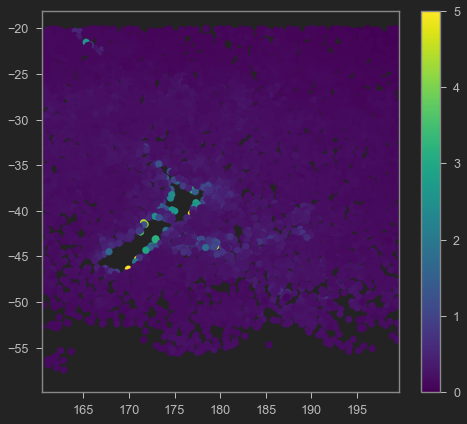

In [184]:
# Visualize for verification
plt.scatter(sat_df["Longitude"][::200], 
            sat_df["Latitude"][::200],
            c=sat_df["Chlorophyll"][::200],
            vmin=0, vmax=5)
plt.colorbar()
plt.axis("equal")
plt.xlim([175,185])

### Lookup Chl-A values
For each station in the BGC argo dataset, look up the nearest lat/long value within correct time period containing Chl-A data in the satellite dataset. Then create dataset to be plotted

In [56]:
# Helper Functions
def findNearestValue(lat, long, day_num, df):
    """Find satellite chl-A value for point closest to input point
    
    Args:
        lat (float): input latitude
        long (float): input longitude
        day_num (int): Overall day number of input point
    
    Returns:
        chl_A_value (float): chl-A value of nearest satellite data point
        nearest_lat (float): Latitiude of nearest data point
        nearest_long (float): Longitude of nearest data point
    """
    time_df = filterByTime(day_num, df)
    nearest_sat_df = findNearestPoint(lat, long, time_df)
    
    chl_A_value = nearest_sat_df["Chlorophyll"]
    nearest_lat = nearest_sat_df["Latitude"]
    nearest_long = nearest_sat_df["Longitude"]
    
    if chl_A_value.count() == 0: # Check if no points were found
        return None, None, None
    else:
        return float(chl_A_value), float(nearest_lat), float(nearest_long)
    
def filterByTime(day_num, df):
    """Filter dataframe for only applicable time periods.
    
    Assumes satellite data has a column containing the first day number of 
    the time period it covers. We want to filter for the time period during which 
    the point was taken, so we want to find the closest day number in the dataset that 
    isn't larger than the input day number
    
    Args:
        day_num (int): Overall day number of input point
        df (DataFrame): Pandas dataframe containing satellite data
        
    Returns:
        time_df (DataFrame): Pandas dataframe containing time-filtered satellite data
    """
    # Find last satellite day number that is less than input day number
    closest_day = df["Overall Day Num"][day_num - df["Overall Day Num"] >=0].max()
    # Create bool array with values we want to keep and use it to filter 
    # out irrelevant timeframes
    time_df = df[df["Overall Day Num"]==closest_day]
    
    return time_df

def findNearestPoint(lat, long, df):
    """ Finds approximate nearest point - first searches latitude, 
    then searches longitude
    
    Doesn't truly find nearest point because that would be more complicated 
    but unneccessary since I'm assuming the data is rather grid-like
    
    Args:
        lat (float): Latitude of point to find in grid
        long (float): Longitude of point to find in grid
        df (DataFrame): pandas dataframe containing grid of satellite points
        
    Returns:
        nearest_chl_a (DataFrame): pandas dataframe containing nearest valid 
            satellite station
    """
    
    lats = df["Latitude"]

    # Compute error for nearest latitude point
    nearest_lat_error = abs(lats-lat).min() 
    # Create bool array where latitude matches
    nearest_lat_idxs = abs(lats-lat) == nearest_lat_error 
    # Use bool array to filter for matching latitude
    lat_sat_df = df[nearest_lat_idxs] 

    # Only look at longitude within matching latitude set
    longs = lat_sat_df["Longitude"] 
    nearest_long_error = abs(longs-long).min()
    nearest_long_idxs = abs(longs-long) == nearest_long_error

    nearest_chl_a = lat_sat_df[nearest_long_idxs]
    
    return nearest_chl_a

### Create Compiled Dataset

In [57]:
compiled_dict = {"Station Num": [],
                 "Overall Day Num": [],
                 "BGC Lat": [],
                 "BGC Long": [],
                 "BGC Chl-A": [],
                 "Sat Lat": [],
                 "Sat Long": [],
                 "Sat Chl-A": [],
#                  "Filename": [],
                } # Initialize empty list for each variable

# TODO: change 10 back to 0
for i in range(10, len(bgc_df)): # For each station in BGC dataset
    print("Compiling data for station " + str(i) + " of " + str(len(bgc_df)))

    stn = bgc_df.iloc[i] # Get BGC data from station 
    # Fill in Station Number
    stn_num = stn["Station Num"]
    compiled_dict["Station Num"].append(stn_num)
    # Fill in Day Number
    day_num = stn["Overall Day Num"]
    compiled_dict["Overall Day Num"].append(day_num)                                  
    # Fill in Latitude
    lat = stn["Latitude [degrees_north]"]
    compiled_dict["BGC Lat"].append(lat)                              
    # Fill in Longitude
    long = stn["Longitude [degrees_east]"]
    compiled_dict["BGC Long"].append(long)                           
    # Fill in BGC Chl-A data
    bgc_chl = stn[BGC_CHL_A_NAME]
    compiled_dict["BGC Chl-A"].append(bgc_chl)                            
    # Compute & fill in Satellite Chl-A data
    sat_chl, sat_lat, sat_long = findNearestValue(lat, long, day_num, sat_df)
    compiled_dict["Sat Lat"].append(sat_lat)
    compiled_dict["Sat Long"].append(sat_long)
    compiled_dict["Sat Chl-A"].append(sat_chl)
    
    if DEBUG and i > 20: # TODO: Remove this
        break
               

compiled_df = pd.DataFrame(compiled_dict)
compiled_df.head()

Compiling data for station 10 of 93
Compiling data for station 11 of 93
Compiling data for station 12 of 93
Compiling data for station 13 of 93
Compiling data for station 14 of 93
Compiling data for station 15 of 93
Compiling data for station 16 of 93
Compiling data for station 17 of 93
Compiling data for station 18 of 93
Compiling data for station 19 of 93
Compiling data for station 20 of 93
Compiling data for station 21 of 93


,Station Num,Overall Day Num,BGC Lat,BGC Long,BGC Chl-A,Sat Lat,Sat Long,Sat Chl-A
0,11,736515,-31.907,185.10800,0.092075,-31.895834,185.104172,0.199990
1,12,736525,-31.564,184.88300,0.097716,-31.562500,184.895828,0.184203
2,13,736535,-31.394,184.89301,0.073814,-31.395834,184.895828,0.178662
3,14,736545,-31.521,184.87801,0.100163,-31.520834,184.895828,0.186937
4,15,736555,-31.627,184.71800,0.115193,-31.645834,184.729172,0.208229


In [69]:
# compiled_df.head()

### Plot Data
Objective: Create a plot that quantifies error between different Chl-A sensors

0.1018455509688638


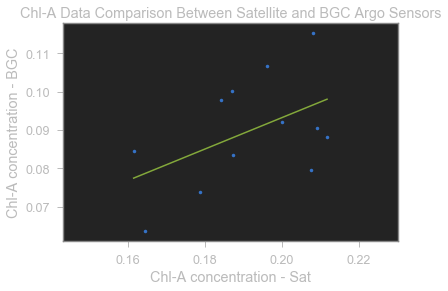

In [89]:
# TODO: Make this object-oriented
compiled_df = compiled_df.dropna() # TODO: make this better
plt.plot(compiled_df["Sat Chl-A"], compiled_df["BGC Chl-A"], '.')

sat_bgc_fit_line = BestFitLine(compiled_df["Sat Chl-A"],
                               compiled_df["BGC Chl-A"])
xp = np.linspace(compiled_df["Sat Chl-A"].min(),
                 compiled_df["Sat Chl-A"].max(),
                 100)
plt.plot(xp, sat_bgc_fit_line.computeY(xp))

# plt.grid

plt.axis("equal")
# plt.xlim([0,0.3])
# plt.ylim([0,0.3])
plt.title("Chl-A Data Comparison Between Satellite and BGC Argo Sensors")
plt.xlabel("Chl-A concentration - Sat")
plt.ylabel("Chl-A concentration - BGC")

print(sat_bgc_fit_line.p_value)

Text(0, 0.5, 'Chl-A concentration')

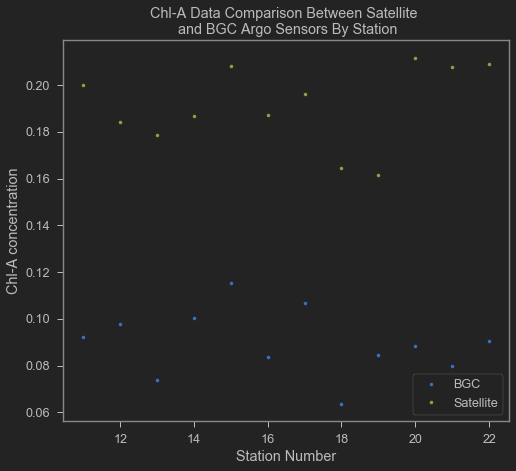

In [176]:
# Comparison by station
# TODO: Make this object-oriented
compiled_df = compiled_df.dropna() # TODO: make this better
plt.plot(compiled_df["Station Num"], compiled_df["BGC Chl-A"], '.')

# TODO: make this prettier 
compile2 = compiled_df.dropna() # Temporary - currently used to filter na values, will be fixed once all data is loaded
plt.plot(compile2["Station Num"], compile2["Sat Chl-A"], '.')
# # compile2
plt.legend(["BGC", "Satellite"])

plt.title("Chl-A Data Comparison Between Satellite \n and BGC Argo Sensors By Station")
plt.xlabel("Station Number")
plt.ylabel("Chl-A concentration")

Text(0.5, 1.0, 'Comparison of used Lat/Long points - BGC and Satellite')

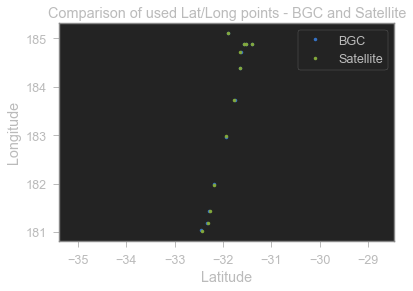

In [61]:

# TODO: Make this object-oriented
plt.plot(compiled_df["BGC Lat"], compiled_df["BGC Long"], '.')
plt.plot(compiled_df["Sat Lat"], compiled_df["Sat Long"], '.')
plt.axis("equal")


plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend(["BGC", "Satellite"])
plt.title("Comparison of used Lat/Long points - BGC and Satellite")

### Load & Format S290 Hydrocast Data

In [166]:
# Helper Functions 
def computeTotalDaysHC(timestamp):
    """Parses timestamp in format yyyy-mm-ddThh:mm:ss.sss from datasets 
    and returns an overall day number used to easily compare various
    datasets.
    
    Args:
        timestamp (str): Timestamp in the format yyyy-mm-ddThh:mm:ss.sss
        
    Returns:
        total_days (float): Overall day number with decimal representing 
            time of day
    """
    days_in_month = np.array([0,31,28,31,30,31,30,31,31,30,31,30,31])
    total_days = days_in_month.cumsum()
    
    year = int(timestamp[0:4])
    month = int(timestamp[5:7])
    day = int(timestamp[8:10])
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    
    total_days = (year * 365 + total_days[month-1] + day) \
        + (hour + minute/60.)/24 # Add in decimal for hour
       
    return total_days

# computeTotalDaysHC("2020-02-18T01:36")


def getStationNum(station_name):
    """Parses station name from hydrocast dataset and returns an int 
    representing station number.
    
    Args:
        station_name (str): Hydrocast station name in the format S290-###-HC
        
    Returns:
        station_num (int): Hydrocast station number
    """
    return int(station_name[5:8])

def correctHCTimestamp(timestamp):
    """Applies correction to HC timestamp - 2020 is incorrectly written as
    0020, so this function returns a new timestamp in the correct format
    
    Args:
        timestamp (str): Incorrect timestamp from hydrocast data
    
    Returns:
        corrected_timestamp (str): Corrected timestamp
    """
    new_timestamp = "2020" + timestamp[4:]
    return new_timestamp
    
# correctHCTimestamp("0020-02-18T01:36")

In [167]:
# To get data, Export>Station Data>ODV Spreadsheet file>Uncheck all exports
hc_df = pd.read_csv("data/data_from_S290-CTD-HC-2.txt", delimiter="\t",header=27)

# Fill in cruise, station, type, date, lat, long, bottom depth with most recent values
col_to_fill = ["Cruise", 
               "Station",
               "Type",
               "yyyy-mm-ddThh:mm:ss.sss",
               "Longitude [degrees_east]",
               "Latitude [degrees_north]",
               "Bot. Depth [m]"]

for col in col_to_fill: hc_df[col].fillna(method="pad", inplace=True)
    
 # Add in column with indices to use
hc_df["Index"] = range(len(hc_df))
# Add in column with station numbers as integers
hc_df["Station Num"] = hc_df["Station"].apply(getStationNum) 
# Add in column with corrected timestamps
hc_df["Corrected Timestamp"] = hc_df["yyyy-mm-ddThh:mm:ss.sss"].apply(correctHCTimestamp)
# Add in overall day numbers
hc_df["Overall Day Num"] = hc_df["Corrected Timestamp"].apply(computeTotalDaysHC)

hc_df.head()

,Cruise,Station,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],Depth [m],Temperature [°C],Salinity [psu],"Density [sigma-theta,Kg/m^3]",Chl a Fluorescence [V],"Oxygen,SBE43 [umol/Kg]",PAR Irradience [uE/m2/s],Chl-a [ug/L],pH,Index,Station Num,Corrected Timestamp,Overall Day Num
0,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,1.0,22.4740,35.5891,24.5315,0.162,217.98700,1150.0,NaN,NaN,0,1,2020-02-18T01:36,737349.066667
1,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,2.0,22.4744,35.5890,24.5314,0.168,217.63499,816.0,NaN,NaN,1,1,2020-02-18T01:36,737349.066667
2,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,3.0,22.5327,35.5881,24.5141,0.179,217.65800,679.0,NaN,NaN,2,1,2020-02-18T01:36,737349.066667
3,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,4.0,22.6162,35.5894,24.4913,0.173,217.75999,555.0,NaN,NaN,3,1,2020-02-18T01:36,737349.066667
4,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,5.0,22.6031,35.5902,24.4957,0.173,217.80600,511.0,NaN,NaN,4,1,2020-02-18T01:36,737349.066667


In [42]:
"""
For computing best fit line, use top several bottles (mixed layer is no deeper than 20m) - can use calibrated values up until that point

Back of the envelope: 1px = 900m, hourly data would be approx 7px - so let's use 60s average data (raw data) instead of the compiled
Raw data is not really useful - things can't change in a couple of seconds

"""

"\nFor computing best fit line, use top several bottles (mixed layer is no deeper than 20m) - can use calibrated values up until that point\n\nBack of the envelope: 1px = 900m, hourly data would be approx 7px - so let's use 60s average data (raw data) instead of the compiled\nRaw data is not really useful - things can't change in a couple of seconds\n\n"

In [168]:
# Extract Chl-A/Fluorometer data
chl_a_data = hc_df["Chl-a [ug/L]"].dropna()
chl_df = hc_df[hc_df.isin(chl_a_data.index)["Index"]==True] # Dataframe to use for calibration

fluor_data = chl_df["Chl a Fluorescence [V]"].dropna()
fluor_chl_df = chl_df[chl_df.isin(fluor_data.index)["Index"]==True]
# Only use data points from up to mixed layer depth
calibration_df_hc = fluor_chl_df[fluor_chl_df["Depth [m]"] < MIXED_LAYER_DEPTH]
calibration_df_hc.head()

,Cruise,Station,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],Depth [m],Temperature [°C],Salinity [psu],"Density [sigma-theta,Kg/m^3]",Chl a Fluorescence [V],"Oxygen,SBE43 [umol/Kg]",PAR Irradience [uE/m2/s],Chl-a [ug/L],pH,Index,Station Num,Corrected Timestamp,Overall Day Num
11007,S290,S290-002-HC,B,0020-02-19T09:12,174.90199,-35.785,128.0,46.0,17.3506,35.4942,25.8113,0.70100,195.79700,NaN,0.214,NaN,11007,2,2020-02-19T09:12,737350.383333
11010,S290,S290-002-HC,B,0020-02-19T09:12,174.90199,-35.785,128.0,75.0,15.5673,35.3885,26.1477,0.10700,179.03799,NaN,0.062,NaN,11010,2,2020-02-19T09:12,737350.383333
11013,S290,S290-002-HC,B,0020-02-19T09:12,174.90199,-35.785,128.0,99.0,14.8271,35.3370,26.2731,0.07400,168.20799,NaN,0.025,NaN,11013,2,2020-02-19T09:12,737350.383333
11018,S290,S290-003-HC,B,0020-02-19T21:43,175.00700,-35.488,280.0,11.0,20.7679,35.6280,25.0358,0.38076,230.69400,NaN,0.196,8.16,11018,3,2020-02-19T21:43,737350.904861
11020,S290,S290-003-HC,B,0020-02-19T21:43,175.00700,-35.488,280.0,37.0,17.8064,35.5039,25.7074,0.50444,214.45599,NaN,0.384,8.10,11020,3,2020-02-19T21:43,737350.904861


2.539546727589068e-11


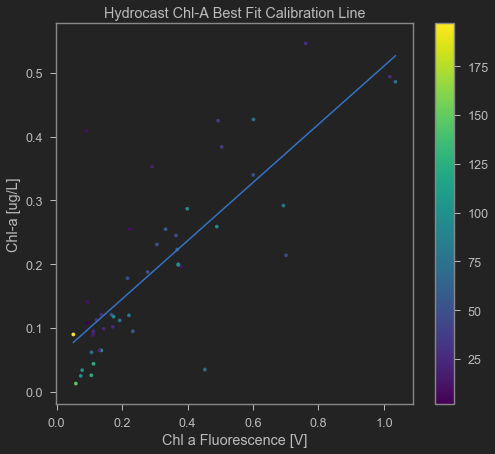

In [169]:
# Get best fit + visualize Chl-A/Fluorometer data
plt.scatter(calibration_df_hc["Chl a Fluorescence [V]"], 
            calibration_df_hc["Chl-a [ug/L]"], 
            c=calibration_df_hc["Depth [m]"],
            marker='.'
            
           )
plt.colorbar()
plt.xlabel("Chl a Fluorescence [V]")
plt.ylabel("Chl-a [ug/L]")
plt.title("Hydrocast Chl-A Best Fit Calibration Line")
        
hc_fit_line = BestFitLine(calibration_df_hc["Chl a Fluorescence [V]"],
                     calibration_df_hc["Chl-a [ug/L]"])

xp = np.linspace(calibration_df_hc["Chl a Fluorescence [V]"].min(),
                 calibration_df_hc["Chl a Fluorescence [V]"].max(),
                 100)
plt.plot(xp, hc_fit_line.computeY(xp))

print(hc_fit_line.p_value)
# plt.xkcd()
# TODO: Find best-fit line r value (basically error, measure of "how good" best fit line is), positive-p value (relationship is definetly greater than 0)

In [170]:
# Apply best fit line to full dataset
hc_df["Calculated Chl-A"] = hc_df["Chl a Fluorescence [V]"].apply(fit_line)
# hc_df

In [171]:
# Filter for surface data only
hc_depth_df = hc_df[hc_df["Depth [m]"]==1]
surface_hc_df = hc_depth_df[hc_depth_df["Type"]=="C"]
# surface_hc_df

In [194]:
# TODO: Make this object-oriented
# plt.plot(compiled_df["BGC Lat"], compiled_df["BGC Long"], '.')
# plt.plot(compiled_df["Sat Lat"], compiled_df["Sat Long"], '.')
# plt.plot(surface_hc_df["Latitude [degrees_north]"], 
#          surface_hc_df["Longitude [degrees_east]"], '.')

# plt.axis("equal")
# plt.xlabel("Latitude")
# plt.ylabel("Longitude")

# plt.legend(["BGC", "Satellite", "S290-HC"])
# plt.title("Comparison of used Lat/Long points")

# hc_df[""]
sat_df["Latitude"].max()
# bgc_df["Latitude [degrees_north]"].max()

-20.02083396911621

### Create Compiled HC Dataset

In [173]:
compiled_dict = {"Station Num": [],
                 "Overall Day Num": [],
                 "HC Lat": [],
                 "HC Long": [],
                 "HC Chl-A": [],
                 "Sat Lat": [],
                 "Sat Long": [],
                 "Sat Chl-A": [],
                } # Initialize empty list for each variable


for i in range(0,len(surface_hc_df)): # For each station in HC dataset
    stn = surface_hc_df.iloc[i] # Get HC data from station
    
    # Fill in Station Number
    stn_num = stn["Station Num"]
    compiled_dict["Station Num"].append(stn_num)
    
    # Fill in Day Number
    day_num = stn["Overall Day Num"]
    compiled_dict["Overall Day Num"].append(day_num)
    
    # Fill in Latitude
    lat = stn["Latitude [degrees_north]"]
    compiled_dict["HC Lat"].append(lat)
    
    # Fill in Longitude
    long = stn["Longitude [degrees_east]"]
    compiled_dict["HC Long"].append(long)
    
    # Fill in HC Chl-A data
    hc_chl = stn["Calculated Chl-A"]
    compiled_dict["HC Chl-A"].append(hc_chl)
    
    # Compute & fill in Satellite Chl-A data
    sat_chl, sat_lat, sat_long = findNearestValue(lat, long, day_num, sat_df)
    compiled_dict["Sat Lat"].append(sat_lat)
    compiled_dict["Sat Long"].append(sat_long)
    compiled_dict["Sat Chl-A"].append(sat_chl)
               

hc_compiled_df = pd.DataFrame(compiled_dict)
hc_compiled_df.head()

,Station Num,Overall Day Num,HC Lat,HC Long,HC Chl-A,Sat Lat,Sat Long,Sat Chl-A
0,1,737349.066667,-36.357,175.17200,0.128090,-36.354168,175.187515,0.518217
1,2,737350.841667,-35.786,174.90199,0.180602,-35.770832,174.895844,0.241729
2,3,737350.363194,-35.488,175.00700,0.163250,-35.479168,175.020844,0.236167
3,4,737351.873611,-35.337,174.83200,0.126720,-35.354168,174.812515,0.218168
4,5,737351.362500,-34.976,174.61400,0.111651,-34.979168,174.604172,0.257413


0.2598313513746133


Text(0, 0.5, 'Chl-A concentration - HC')

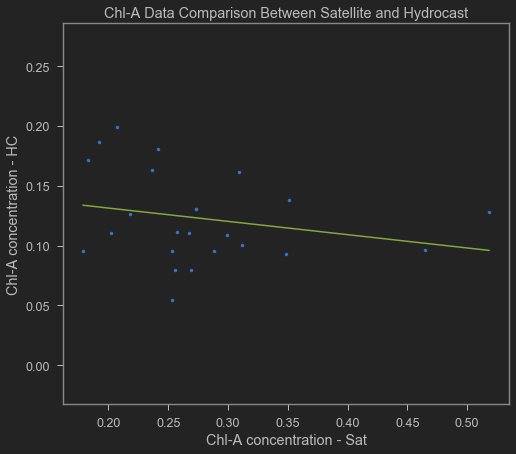

In [175]:
# TODO: Make this object-oriented
plt.axis("equal")
# plt.xlim([0,0.4])
# plt.ylim([0,0.4])
plt.plot(hc_compiled_df["Sat Chl-A"], hc_compiled_df["HC Chl-A"], '.')

hc_sat_fit_line = BestFitLine(hc_compiled_df["Sat Chl-A"],
                              hc_compiled_df["HC Chl-A"])

xp = np.linspace(hc_compiled_df["Sat Chl-A"].min(),
                 hc_compiled_df["Sat Chl-A"].max(),
                 100)
plt.plot(xp, hc_sat_fit_line.computeY(xp))

print(hc_sat_fit_line.p_value)

plt.title("Chl-A Data Comparison Between Satellite and Hydrocast")
plt.xlabel("Chl-A concentration - Sat")
plt.ylabel("Chl-A concentration - HC")


Text(0, 0.5, 'Chl-A concentration')

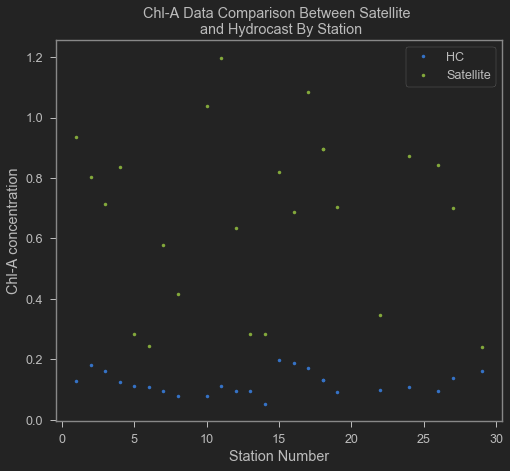

In [50]:



# Comparison by station
plt.plot(hc_compiled_df["Station Num"], hc_compiled_df["HC Chl-A"], '.')
plt.plot(hc_compiled_df["Station Num"], hc_compiled_df["Sat Chl-A"], '.')

plt.legend(["HC", "Satellite"])

plt.title("Chl-A Data Comparison Between Satellite \n and Hydrocast By Station")
plt.xlabel("Station Number")
plt.ylabel("Chl-A concentration")

Text(0.5, 1.0, 'Comparison of used Lat/Long points - HC and Satellite')

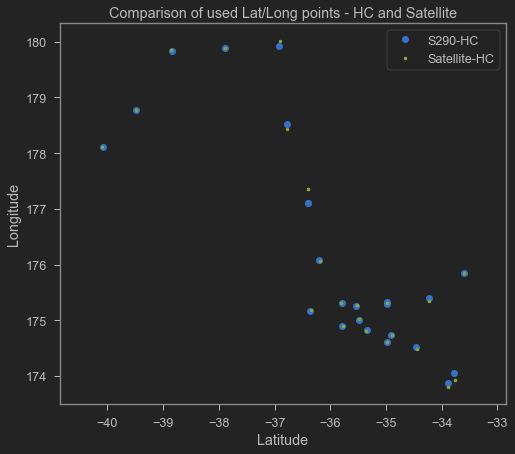

In [181]:
# TODO: Make this object-oriented
plt.plot(hc_compiled_df["HC Lat"], hc_compiled_df["HC Long"], 'o')
plt.plot(hc_compiled_df["Sat Lat"], hc_compiled_df["Sat Long"], '.')

plt.axis("equal")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.legend(["S290-HC", "Satellite-HC"])
plt.title("Comparison of used Lat/Long points - HC and Satellite")

(175, 185)

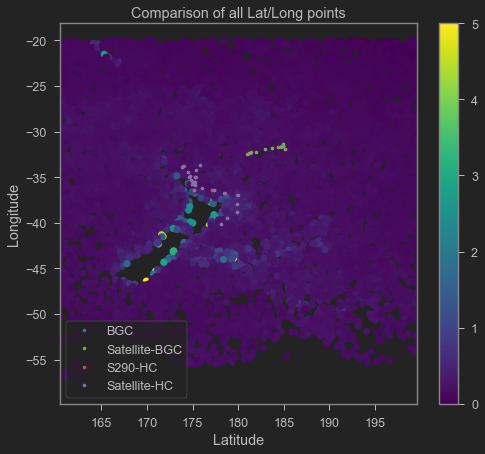

In [187]:
# TODO: Make this object-oriented

plt.scatter(sat_df["Longitude"][::200], 
            sat_df["Latitude"][::200],
            c=sat_df["Chlorophyll"][::200],
            vmin=0, vmax=5)
plt.colorbar()

plt.plot(compiled_df["BGC Long"], compiled_df["BGC Lat"], '.')
plt.plot(compiled_df["Sat Long"], compiled_df["Sat Lat"], '.')
plt.plot(hc_compiled_df["HC Long"], hc_compiled_df["HC Lat"], '.')
plt.plot(hc_compiled_df["Sat Long"], hc_compiled_df["Sat Lat"], '.')

plt.axis("equal")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.legend(["BGC", "Satellite-BGC", "S290-HC", "Satellite-HC"])
plt.title("Comparison of all Lat/Long points")
plt.xlim([175,185])

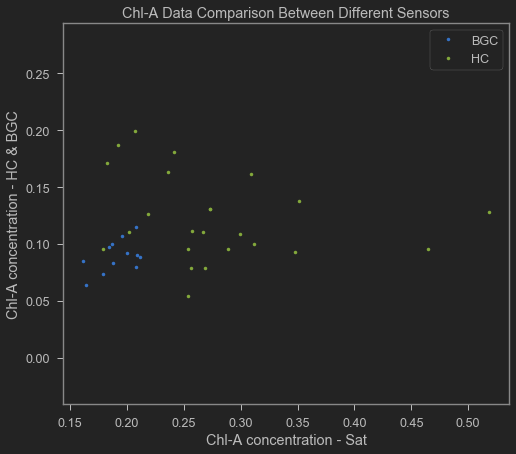

In [165]:
# TODO: Make this object-oriented
plt.axis("equal")

plt.plot(compiled_df["Sat Chl-A"], compiled_df["BGC Chl-A"], '.')
plt.plot(hc_compiled_df["Sat Chl-A"], hc_compiled_df["HC Chl-A"], '.')

plt.axis("equal")
plt.title("Chl-A Data Comparison Between Different Sensors")
plt.xlabel("Chl-A concentration - Sat")
plt.ylabel("Chl-A concentration - HC & BGC")
plt.legend(["BGC", "HC"])

# # TODO: Make this object-oriented
# compiled_df = compiled_df.dropna() # TODO: make this better
# plt.plot(compiled_df["Sat Chl-A"], compiled_df["BGC Chl-A"], '.')


### Flow-through (old)

In [27]:
hourly_df = pd.read_csv("data/S290_Hourlywork_isosurface_data.txt", delimiter="\t",header=1)

FileNotFoundError: File b'data/S290_Hourlywork_isosurface_data.txt' does not exist

In [28]:
hourly_df.dropna(inplace=True)
# Add in column with indices to use
hourly_df["Index"] = range(len(hourly_df))
# hourly_df

NameError: name 'hourly_df' is not defined

In [29]:
# Helper functions
def computeTotalHours(timestamp):
    """Computes the total hours to use as a basis for comparison
    
    Args:
        timestamp (str): timestamp in format yyyy-mm-ddThh:mm:ss.sss
        
    Returns:
        total_hrs (int): total number of hours elapsed
    """
    hour   = int(timestamp[11:13])
    minute = float(timestamp[14:])
    
    total_days = computeTotalDays(timestamp)
    total_hrs = int(round(total_days*24 + hour + minute/60))
    
    return total_hrs
    
def findNearestTime(timestamp, df, col="yyyy-mm-ddThh:mm:ss.sss"):
    """Finds the index nearest timestamp in the specified df.
    Dates are assumed to be in the format yyyy-mm-ddThh:mm:ss.sss
    
    Args:
        timestamp (str): timestamp to find in dataframe
        df (DataFrame): pandas dataframe containing data to be searched through
        col (str): Column to use for the timestamp
        
    Returns:
        nearest_idx (int): Index of dataframe that has the closest timestamp
    """
    
    hours_total_df = df[col].apply(computeTotalHours)
    differences = abs(hours_total_df - computeTotalHours(timestamp))
    min_difference = differences.min()
    print("Diff: " + str(min_difference))
    nearest_idx = int(df[differences==min_difference]["Index"].iloc[0]) # If two are equally close, pick first value
    return nearest_idx
    
# computeTotalHours("2020-02-19T21:43")
findNearestTime("2020-02-19T21:43", hourly_df)

NameError: name 'hourly_df' is not defined

In [30]:
# Create calibration dataset
nearest_hourly_idxs = []

for i in range(0,len(fluor_chl_df)): # For each station in calibration dataset
    stn = fluor_chl_df.iloc[i] # Get data from station
#     print(stn)
    time = stn["Corrected Timestamp"]
    print(time)
    nearest_idx = findNearestTime(time, hourly_df)
    nearest_hourly_idxs.append(nearest_idx)
    
nearest_hourly_idxs

2020-02-19T09:12


NameError: name 'hourly_df' is not defined

In [31]:
"""
for station in hc dataset (fluor dataset where depth is 1, calibrated values)


find_nearest_date
    retun index

Result: list of indices, size 1:1 to fluor dataset to use for calibration

"""

'\nfor station in hc dataset (fluor dataset where depth is 1, calibrated values)\n\n\nfind_nearest_date\n    retun index\n\nResult: list of indices, size 1:1 to fluor dataset to use for calibration\n\n'

In [32]:
a = pd.Series([True, True, False])
a.

SyntaxError: invalid syntax (<ipython-input-32-4339d20ae27f>, line 2)

In [33]:
round(12.69)

13

In [34]:
""" 
Hourly data from previous cruise tracks
Our 1min binned flow through data"""

' \nHourly data from previous cruise tracks\nOur 1min binned flow through data'

### Load & Format S290 1-min Binned Flow-Through Data

In [107]:
ft_filename = "data/Event60sec_003.elg"

In [127]:
# Helper functions
def computeDegreesDecimalFT(gps_val):
    """Converts latitude or longitude value from flow-through dataset
    into a compatible numerical value. 
    Example input values:
        3650.1777S = 36 degrees, 50.1777 minutes South
        4136.8718S = 41 degrees, 36.8718 minutes South
        17446.9143E = 174 degrees, 46.9143 minutes East
        17959.6199W = 179 degrees, 59.6199 minutes West
    
    Args:
        gps_val (str): Input latitude or longitude value to be converted
        
    Output:
        gps_num (float): GPS input value in decimal form. Latitude range
            [-90, 90], Longitude range [0, 360]
    """
    dec_idx = gps_val.find(".") 
    degrees = int(gps_val[:dec_idx-2]) # Degrees
    minutes = float(gps_val[dec_idx-2:dec_idx+4]) # Minutes
    decimal = minutes/60.
    
    gps_num = degrees + decimal
    
    if gps_val[-1] == "S":
        gps_num = (gps_num*-1) 
    elif gps_val[-1] == "W":
        gps_num = (gps_num*-1) % 360 # Convert from [-180 180] to [0 360]
        
    return gps_num

def computeTotalDaysFT(df_row):
    """Computes the total days to use as a basis for comparison from 
    flow-through dataset
    
    Args:
        df_row (DataFrame): row of flow-through dataset
        
    Returns:
        total_days (float): Total number of days elapsed with decimal
            representing time of day
    """
    date = df_row["Date"]
    time = df_row["Time"]
    
    days_in_month = np.array([0,31,28,31,30,31,30,31,31,30,31,30,31])
    total_days = days_in_month.cumsum()
    
    year   = int(date[6:10])
    month  = int(date[0:2])
    day    = int(date[3:5])
    hour   = int(time[0:2])
    minute = float(time[3:].replace(':','.'))
    
    total_days = (year * 365 + total_days[month-1] + day) \
        + (hour + minute/60.)/24 # Add in decimal for hour
       
    return total_days

In [128]:
ft_df = pd.read_csv(ft_filename, delimiter=",",header=0)
# Remove unnecessary columns
ft_df.dropna(axis=1, inplace=True) 
# Add in column with indices to use
ft_df["Index"] = range(len(ft_df))
# Add in column with properly formatted latitude
ft_df["Latitude"] = ft_df["GPS-nav-Lat"].apply(computeDegreesDecimalFT)
# Add in column with properly formatted longitude
ft_df["Longitude"] = ft_df["GPS-nav-Lon"].apply(computeDegreesDecimalFT)
# Add in column with total days
ft_df["Overall Day Num"] = ft_df.apply(computeTotalDaysFT, axis=1)

ft_df.head()

,Date,Time,GPS-nav-time,GPS-nav-Lat,GPS-nav-Lon,GPS-nav-SOG,GPS-nav-COG,GPS-lab-time,GPS-lab-Lat,GPS-lab-Lon,ADU5-Heading,Wind-Dir,WIND-Spd,TRUE-WIND-Speed,TRUE-WIND-Direction,Seatex-MRU-Roll,Seatex-MRU-Pitch,Fluor-CDOM-avg-1-mins-Value,Fluor-CDOM-avg-60-mins-Value,LCI90-payout,LCI90-Spd,LCI90-tension,Xmiss-NewDigital-1-min-Value,Xmiss-NewDigital-avg-60-min-Value,Index,Latitude,Longitude,Overall Day Num
0,02/16/2020,20:03:55,200403,3650.1777S,17446.9062E,6.4,78.8,200403,3650.1769S,17446.9143E,97.353,329,13,7.31,41.18,2.36,2.33,129.14,129.14,0.0,0.0,25.4563,1521.73,1521.73,0,-36.836283,174.781767,737347.835799
1,02/16/2020,20:04:55,200503,3650.1931S,17447.0322E,6.1,79.6,200503,3650.1913S,17447.0391E,95.281,316,13,9.05,33.94,2.61,1.60,129.83,129.83,0.0,0.0,28.7531,1737.70,1737.70,1,-36.836550,174.783867,737347.836493
2,02/16/2020,20:05:55,200603,3650.2074S,17447.1578E,6.1,79.5,200603,3650.2052S,17447.1666E,95.043,335,12,5.98,65.90,2.64,1.42,128.73,128.73,0.0,0.0,25.5675,2096.27,2096.27,2,-36.836783,174.785950,737347.837187
3,02/16/2020,20:06:55,200703,3650.2218S,17447.2817E,6.0,81.0,200703,3650.2227S,17447.2897E,100.560,329,11,5.26,53.93,2.43,1.33,129.23,129.27,0.0,0.0,27.2659,1832.00,1832.00,3,-36.837017,174.788017,737347.837882
4,02/16/2020,20:07:55,200803,3650.2423S,17447.4067E,6.1,81.2,200803,3650.2421S,17447.4153E,100.023,327,12,5.09,58.06,2.18,1.47,129.73,129.67,0.0,0.0,32.1057,1670.03,1670.03,4,-36.837367,174.790100,737347.838576


### Calibrate S290 1-min Binned Flow-Through Data
Look for nearest matching timestamp of flow-through data with calibrated hydrocast data points

In [ ]:
def findNearestTimeFT(day_num, df, col="Overall Day Num"):
    """
     Args:
         day_num (str): timestamp to find in dataframe
         df (DataFrame): pandas dataframe containing data to be searched through
         col (str): Column to use for the timestamp
       
     Returns:
         nearest_idx (int): Index of dataframe that has the closest timestamp
    """

# def findNearestTimeFT(timestamp, df, col="yyyy-mm-ddThh:mm:ss.sss"):
#     """Finds the index nearest timestamp in the specified df.
#     Dates are assumed to be in the format yyyy-mm-ddThh:mm:ss.sss
    
#     Args:
#         timestamp (str): timestamp to find in dataframe
#         df (DataFrame): pandas dataframe containing data to be searched through
#         col (str): Column to use for the timestamp
        
#     Returns:
#         nearest_idx (int): Index of dataframe that has the closest timestamp
#     """
    
#     hours_total_df = df[col].apply(computeTotalHours)
#     differences = abs(hours_total_df - computeTotalHours(timestamp))
#     min_difference = differences.min()
#     print("Diff: " + str(min_difference))
#     nearest_idx = int(df[differences==min_difference]["Index"].iloc[0]) # If two are equally close, pick first value
#     return nearest_idx
    
# # computeTotalHours("2020-02-19T21:43")
# findNearestTime("2020-02-19T21:43", hourly_df)
# ft_df.apply(computeTotalHoursFT, axis=1)

In [ ]:
calibration_df_ft

In [ ]:
def testfunc(asdf):
#     print(asdf[GPS-nav-time])
    pass
    return asdf["GPS-nav-time"]

ft_df.apply(testfunc, axis=1)



In [ ]:
a = "adsf:asdf"
a.replace(':','.')

In [37]:
ft_df["Latitude"] = ft_df["GPS-nav-Lat"].apply(computeDegreesDecimal)
ft_df["Longitude"] = ft_df["GPS-nav-Lon"].apply(computeDegreesDecimal)
ft_df.columns

NameError: name 'computeDegreesDecimal' is not defined

In [38]:
ft_df

,Date,Time,GPS-nav-time,GPS-nav-Lat,GPS-nav-Lon,GPS-nav-SOG,GPS-nav-COG,GPS-lab-time,GPS-lab-Lat,GPS-lab-Lon,...,Seatex-MRU-Roll,Seatex-MRU-Pitch,Fluor-CDOM-avg-1-mins-Value,Fluor-CDOM-avg-60-mins-Value,LCI90-payout,LCI90-Spd,LCI90-tension,Xmiss-NewDigital-1-min-Value,Xmiss-NewDigital-avg-60-min-Value,Index
0,02/16/2020,20:03:55,200403,3650.1777S,17446.9062E,6.4,78.8,200403,3650.1769S,17446.9143E,...,2.36,2.33,129.14,129.14,0.0,0.0,25.4563,1521.73,1521.73,0
1,02/16/2020,20:04:55,200503,3650.1931S,17447.0322E,6.1,79.6,200503,3650.1913S,17447.0391E,...,2.61,1.60,129.83,129.83,0.0,0.0,28.7531,1737.70,1737.70,1
2,02/16/2020,20:05:55,200603,3650.2074S,17447.1578E,6.1,79.5,200603,3650.2052S,17447.1666E,...,2.64,1.42,128.73,128.73,0.0,0.0,25.5675,2096.27,2096.27,2
3,02/16/2020,20:06:55,200703,3650.2218S,17447.2817E,6.0,81.0,200703,3650.2227S,17447.2897E,...,2.43,1.33,129.23,129.27,0.0,0.0,27.2659,1832.00,1832.00,3
4,02/16/2020,20:07:55,200803,3650.2423S,17447.4067E,6.1,81.2,200803,3650.2421S,17447.4153E,...,2.18,1.47,129.73,129.67,0.0,0.0,32.1057,1670.03,1670.03,4
5,02/16/2020,20:08:55,200903,3650.2638S,17447.5313E,6.1,82.1,200903,3650.2644S,17447.5387E,...,2.43,1.45,129.30,129.47,0.0,0.0,34.7809,1497.53,1495.70,5
6,02/16/2020,20:09:55,201003,3650.2834S,17447.6560E,6.1,81.4,201003,3650.2856S,17447.6660E,...,2.30,1.39,129.07,128.97,0.0,0.0,16.8322,1257.03,1257.03,6
7,02/16/2020,20:10:55,201103,3650.3028S,17447.7808E,6.1,81.2,201103,3650.3031S,17447.7881E,...,2.26,1.29,130.37,130.37,0.0,0.0,29.7416,999.53,973.37,7
8,02/16/2020,20:11:55,201203,3650.3200S,17447.9072E,6.1,79.0,201203,3650.3183S,17447.9181E,...,2.90,1.12,129.93,129.83,0.0,0.0,33.0050,2019.57,2019.57,8
9,02/16/2020,20:12:55,201303,3650.3279S,17448.0350E,6.2,75.8,201303,3650.3263S,17448.0434E,...,2.36,2.17,130.40,130.43,0.0,0.0,40.4411,2042.57,2042.57,9


In [39]:
test = "17609.7255E"


In [40]:
dec_idx = test.find(".")
test[dec_idx-2:dec_idx+4] # Minutes
test[:dec_idx-2] # Degrees


'176'

In [41]:

computeDegreesDecimal("3650.1777S")

def testFunc(a):
    if a[-1] == "E":
#         print("here1")
        pass
    elif a[-1] == "W":
        print(a)
    else:
        print("oops")
ft_df["GPS-lab-Lon"].apply(testFunc)

# ft_df


NameError: name 'computeDegreesDecimal' is not defined

In [42]:
# NET CDF TEST
import netCDF4
import pandas as pd


nc = netCDF4.Dataset("data\V20193532019360.L3m_8D_SNPP_CHL.x_chlor_a.nc", mode='r')

# precip_nc_file = 'C:\Users\aphung\Documents\SEA OFFLINE\NZ_GPS_chlorophyll_full\V20200092020016.L3m_8D_SNPP_CHL.x_chlor_a.nc'
# nc = netCDF4.Dataset(precip_nc_file, mode='r')

nc.variables.keys()

lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
chlor_a = nc.variables['chlor_a'][:]
# # dtime = netCDF4.num2date(time_var[:],time_var.units)
# # precip = nc.variables['precip'][:]
#len(lat.data) #1080
# len(lon.data) #8640
# len(chlor_a.data)
chl_df = pd.DataFrame(chlor_a.data)
chl_df

# chlor_a
# data = pd.DataFrame([lat.data, lon.data, chlor_a.data], columns=["Latitude", "Longitude", "Chl-A"])
# data
# # a pandas.Series designed for time series of a 2D lat,lon grid
# precip_ts = pd.Series(precip, index=dtime) 

# precip_ts.to_csv('precip.csv',index=True, header=True)

,0,1,2,3,4,5,6,7,8,9,...,8630,8631,8632,8633,8634,8635,8636,8637,8638,8639
0,0.123839,0.113159,0.113164,0.119788,0.118493,0.118657,-32767.000000,-32767.000000,-32767.000000,-32767.000000,...,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.0,-32767.0,-32767.0,0.127105,0.126921,0.123637
1,0.123839,0.124661,0.123373,0.119787,0.118493,0.118656,-32767.000000,-32767.000000,-32767.000000,-32767.000000,...,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.0,-32767.0,-32767.0,0.125705,0.125587,0.123678
2,-32767.000000,0.117053,0.117484,0.116287,0.114426,0.113763,-32767.000000,-32767.000000,-32767.000000,-32767.000000,...,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.0,-32767.0,-32767.0,-32767.000000,-32767.000000,-32767.000000
3,-32767.000000,0.117053,0.117063,0.116627,0.116106,0.101741,0.101741,-32767.000000,-32767.000000,-32767.000000,...,-32767.000000,-32767.000000,0.207998,0.207998,-32767.0,-32767.0,-32767.0,-32767.000000,-32767.000000,-32767.000000
4,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.000000,0.101741,0.101741,-32767.000000,-32767.000000,-32767.000000,...,-32767.000000,-32767.000000,0.207998,0.207998,-32767.0,-32767.0,-32767.0,-32767.000000,-32767.000000,-32767.000000
5,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.000000,...,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.0,-32767.0,-32767.0,0.249396,0.249396,-32767.000000
6,-32767.000000,-32767.000000,-32767.000000,-32767.000000,0.161482,0.153628,0.149962,-32767.000000,-32767.000000,-32767.000000,...,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.0,-32767.0,-32767.0,0.249396,0.249396,-32767.000000
7,-32767.000000,-32767.000000,-32767.000000,-32767.000000,0.161485,0.153630,0.149964,-32767.000000,-32767.000000,-32767.000000,...,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.0,-32767.0,-32767.0,0.198245,0.198618,0.201646
8,-32767.000000,-32767.000000,-32767.000000,-32767.000000,0.178019,0.175224,0.173254,-32767.000000,-32767.000000,-32767.000000,...,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.0,-32767.0,-32767.0,0.198245,0.198618,0.201646
9,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.000000,0.160244,0.160244,-32767.000000,0.098570,0.098011,...,-32767.000000,-32767.000000,-32767.000000,-32767.000000,-32767.0,-32767.0,-32767.0,-32767.000000,-32767.000000,-32767.000000


In [43]:
chl_df.values.flatten()

array([ 1.2383877e-01,  1.1315882e-01,  1.1316373e-01, ...,
       -3.2767000e+04, -3.2767000e+04, -3.2767000e+04], dtype=float32)

In [44]:
a = np.meshgrid(lat.data, lon.data)
# a

In [45]:
lat.data

array([-20.020834, -20.0625  , -20.104166, ..., -64.895836, -64.9375  ,
       -64.97917 ], dtype=float32)

In [46]:
list1 = lat.data
list2 = lon.data

import itertools

all_combinations = [list(zip(each_permutation, list2)) for each_permutation in itertools.permutations(list1, len(list2))]


In [47]:
all_combinations

[]

In [48]:
list2

array([-179.97917, -179.9375 , -179.89583, ...,  179.89584,  179.93752,
        179.97917], dtype=float32)

In [49]:
a = [list2, list1]

lat_long_list = list(itertools.product(*a))

In [50]:
len(chl_df.values.flatten())

9331200

In [51]:
test = pd.DataFrame(lat_long_list, columns=["Latitude", "Longitude"])
test["Chlorophyll"] = chl_df.values.flatten()
test

,Latitude,Longitude,Chlorophyll
0,-179.979172,-20.020834,0.123839
1,-179.979172,-20.062500,0.113159
2,-179.979172,-20.104166,0.113164
3,-179.979172,-20.145834,0.119788
4,-179.979172,-20.187500,0.118493
5,-179.979172,-20.229166,0.118657
6,-179.979172,-20.270834,-32767.000000
7,-179.979172,-20.312500,-32767.000000
8,-179.979172,-20.354166,-32767.000000
9,-179.979172,-20.395834,-32767.000000


In [64]:
test.replace(-32767.000000, np.nan, inplace=True)

In [65]:
test.apply()

SyntaxError: invalid syntax (<ipython-input-65-4cc5a1d62b27>, line 1)

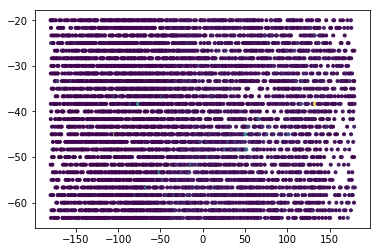

In [58]:
plt.scatter(test["Latitude"][::1000], test["Longitude"][::1000], c=test["Chlorophyll"][::1000],
            marker='.')

In [ ]:
def loadSatelliteDataOLD_VERSION(sat_data_dir):
    """Wrapper function for loading satellite data
    
    Args:
        sat_data_dir (str): string representing file location of all satellite data
    
    Returns:
        sat_df (DataFrame): pandas dataframe containing clean satellite data with chlA values
    """
    sat_df = pd.DataFrame()
    
    for f in glob.glob('%s/*.nc' % sat_data_dir): # Iterate through files in sat_data_dir
        print(f)
        year, day = parseFilenameDate(f)
        nc = netCDF4.Dataset(f, mode='r')

        lat = nc.variables['lat'][:]
        lon = nc.variables['lon'][:]
        chlor_a = nc.variables['chlor_a'][:]

        chl_df = pd.DataFrame(chlor_a.data)

#         lat_long = [lon.data, lat.data]
#         lat_long_list = list(itertools.product(*lat_long)) # TODO: Find a better way to do this - too time consuming
        new_df = pd.DataFrame()
        new_df["Chlorophyll"] = chl_df.values.flatten()
        new_df["Index"] = range(0,len(new_df))
        new_df["Latitude"] = new_df["Index"].apply(fillLatitude, args=(lat.data, lon.data))
        new_df["Longitude"] = new_df["Index"].apply(fillLongitude, args=(lat.data, lon.data))
#         new_df = pd.DataFrame(lat_long_list, columns=["Latitude", "Longitude"])
        

        sat_df = pd.concat([new_df, sat_df])
        

        
#         new_df = pd.read_csv(f, delimiter="\t",header=1)
#         new_df["Time [yr]"] = int(year) # Add year to dataframe
#         new_df["Day of Year"] = int(day) # Add day of year to dataframe
#         sat_df = pd.concat([new_df, sat_df])
    
#     sat_df.dropna(axis=1, how='all', inplace=True) # Remove unused columns
#     sat_df.dropna(inplace=True) # Drop points missing chlorophyll values
#     sat_df["Overall Day Num"] = sat_df["Time [yr]"].astype(int) * 365 + sat_df["Day of Year"] # Add in column with total days
    
    return sat_df

## Notes

In [ ]:
"""
In Wellington

Priority:
Figure out maps in python
Figure out .nc file opening
Get up to date satellite data 

Other:
Offline latex
Images

Papers:
Satellite sampling depth
Satellite resolution/exact sensors used
BGC sensors used
Our sensors
Look at paper to find things that need documentation


Notes:
Challenges? - in our area, lots of different levels of chlorophyll - makes it difficult to pinpoint - using most sensitive range, but it has three levels of sensitivity
Explain integration to 20 with figures

Publish code (put online + link ok)
Should include description of code (how it got there)
Find more literature on sensors to add to intro

Throw in figures - throw in "typical" profiles to verify 20 is valid

Data source should also go in methods

Questions:
hc timestamp - 0020
B and C types in dataset: bottle vs ctd - bottle is snapshot values (subject to noise), ctd is averaged by bin (1m bins) - Bottle depth values currently broken, will be fixed later 
fluor_chl_df - identical timestamps, very different values - because of broken values
Surface data calibration - should I use flow through data instead of hc data?
Chl-a accuracy in papers? difficult to find - ask jan about virs dataset documentation in wellington, reason through fluromoter calibration - fluorometers are only as good as their calibration
Previous cruise track data - getting now on flash drive, in wellington, ask about getting 1m data opposed to hourly

Questions V2:
Using only 20 m depth makes a pretty crappy calibration curve

Figures:
Depth comparison of BGC & us?

Code To-Do:
properly calibrate hydrocast dataset - didn't work too well
import + parse new flow through data - in progress - writing nearest timestamp lookup function
properly calibrate new flow through data
import + parse old cruise data (hourly, hydrocast)
make plot with all cruise tracks
try using old data in calibration?

Blocked:
Satellite data source?
Getting 1m binned data from prior years

Things to verify:
Satellite data source is correct and optimal
Satellite data lat/long/chlorophyll values are lining up properly (I have a hunch they're not)


"""